# Road Point Cloud Classification
1. Data Loader
2. Tree-based methods and SVM
3. Convolutional Neural Network


In [25]:
# install required packages
%pip install -r requirements.txt

  Using cached torchvision-0.22.1-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement open3d (from versions: none)
ERROR: No matching distribution found for open3d


In [4]:
# Basic data processing & preparation functionality
import os
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import cv2

# Visualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import visualtorch
import nbformat as nbf

# Measurements of time to fit a model
import time

#   Tree-based methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#   SVM related methods
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

# Data preprocessing
from sklearn.model_selection import train_test_split

# Dataset tuning
from sklearn.decomposition import PCA

# Model tuning
from sklearn.model_selection import GridSearchCV

# Metric for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score, make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Deep learning methods
from tqdm import tqdm
%pip install --upgrade torch torchvision --quiet

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
import torchvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
# --- Road Point Cloud Classification - Data Loader --- (Jonas)

# Function to load all point clouds from a folder
def load_point_clouds(labels, folder_path="dataset/"):
    """
    Loads all .npy point cloud files from the specified folder.

    Args:
        folder_path (str): Path to the folder containing .npy files.

    Returns:
        list of np.ndarray: List of loaded point cloud arrays.
    """
    point_clouds = []
    for label in labels:
        folder = f"{folder_path}{label}"  # Adjust the folder paths as needed
        for filename in os.listdir(folder):
            if filename.endswith('.npy'):
                file_path = os.path.join(folder, filename)
                data = np.load(file_path)
                # print(data.shape)  # Print shape of each loaded point cloud
                label_vector = np.zeros((data.shape[0], 1))  # Create a label vector of zeros
                label_vector.fill(labels.index(label))  # Fill the label vector with the index of the label
                data = np.hstack((data, label_vector))  # Concatenate label vector to the point cloud data
                # print(data.shape)  # Print shape after concatenation
                point_clouds.append(data)
    return point_clouds

def visualize_point_cloud(points, title="Point Cloud", s=2):
    """
    Visualizes a 3D point cloud using ipyvolume.

    Args:
        points (np.ndarray): Array of shape (N, 3) or (N, >=3) with x, y, z coordinates.
        title (str): Plot title.
        s (float): Marker size.
    """
    if points.shape[1] < 3:
        raise ValueError("Point cloud must have at least 3 columns (x, y, z).")
    color = []
    for i in range(points.shape[0]):
        color.append(np.hstack((points[i,3] / 255, points[i,4] /255, points[i,5] / 255)))
    frm = pd.DataFrame(points[:, :6], columns=['x', 'y', 'z', 'r', 'g', 'b'])
    fig = go.Figure(data=[go.Scatter3d(
        x=frm['x'],
        y=frm['y'],
        z=frm['z'],
        mode='markers',
        marker=dict(
            size=s,
            color=color,  # Use RGB colors
            opacity=0.8
        ))])
    fig.update_layout(
    scene=dict(
        aspectmode='data'
    ),
    width=1000,
    height=800
    )

    fig.show()

# Tree-based methods and SVM

For tree-based methods and support vector machines, a one-dimensional feature vector is needed as input data for every sample of the dataset. Therefore, in a first, basic approach, we simply downsampled each point cloud randomly to the number of points of the smallest point cloud in the dataset. Another option would be padding all samples of the dataset by adding dummy points to match the shape of the point cloud with the most points. Downsampling each point cloud would also be the main drawback of this approach as in some cases a huge amount of information about the point cloud gets lost (The smallest point cloud contains 510 points, while the largest one features 16661 points).

Afterwards, we prepared the input feature matrix X by simply concatenating all selected features for all the points for each point cloud. As this approach resulted in quite poor accuracies, we figured out that this approach doesn´t make much sense anyways as the model would compare the features of several points within the point cloud simply based on its index within the point cloud. Therefore, we also tried to calculate the feature means over all points within a point cloud. This approach gave us slightly better results, but is obviously still quite unprecise as the mean feature value over all points doesn´t really give much information about unique aspects of a point cloud. In general, tree-based methods and SVM are simply not the very best approaches to deal with high-dimensional but relatively small point cloud data.

In [6]:
# --- Data Preparation for tree-based methods and SVM --- (Jonas)

def downsample_point_clouds(dataset, min_points=-1):
    """
    Downsamples all point clouds in the dataset to the size of the first point cloud.

    Args:
        dataset (list of np.ndarray): List of point clouds.

    Returns:
        list of np.ndarray: List of downsampled point clouds.
    """
    if not dataset:
        return []

    # Sort the dataset by the number of points in each point cloud
    dataset.sort(key=lambda x: x.shape[0])
    print(f"Shape of smallest point cloud: {dataset[0].shape}")  # Print the shape of the first point cloud
    print(f"Shape of largest point cloud: {dataset[-1].shape}")  # Print the shape of the last point cloud
    if min_points == -1:
        min_points = dataset[0].shape[0]
    else:
        #remove all point clouds with fewer points than min_points
        dataset = [sample for sample in dataset if sample.shape[0] >= min_points]
    # Downsample all point clouds to the size of the first point cloud or to min_points if specified
    for i in range(len(dataset)):
        sample = dataset[i]  # Get the current sample
        indices = np.random.choice(sample.shape[0], size=min_points, replace=False)  # Randomly select indices
        sample_downsampled = sample[indices]  # Downsample the point cloud to match the size of the first point cloud 
        dataset[i] = sample_downsampled  # Update the dataset with the downsampled sample

    return dataset


def pad_point_clouds(dataset):
    """
    Pads all point clouds in the dataset to the size of the largest point cloud.

    Args:
        dataset (list of np.ndarray): List of point clouds.

    Returns:
        list of np.ndarray: List of padded point clouds.
    """
    if not dataset:
        return []

    max_size = max(sample.shape[0] for sample in dataset)  # Find the maximum size of point clouds
    padded_dataset = []

    for sample in dataset:
        if sample.shape[0] < max_size:
            padding = np.zeros((max_size - sample.shape[0], sample.shape[1]))  # Create padding
            padded_sample = np.vstack((sample, padding))  # Stack the original sample with padding
        else:
            padded_sample = sample  # No padding needed
        padded_dataset.append(padded_sample)  # Append the padded sample to the new dataset

    return padded_dataset


def prepare_feature_vectors(dataset):
    """
    Prepares feature vectors and labels from the dataset of point clouds.

    Args:
        dataset (list of np.ndarray): List of downsampled point clouds.

    Returns:
        tuple: Feature vectors (X) and labels (y).
    """
    # Convert the list of point clouds to a single NumPy array
    feature_vectors = []
    target_labels = []  # Initialize a list to store labels
    for sample in dataset:
        feature_vector = np.array([])  # Initialize an empty array for the feature vector
        # Iterate over each point in the sample and concatenate its features to the feature vector
        for i in range(sample.shape[0]):
            feature_vector = np.hstack((feature_vector, sample[i, :-1]))
        target_labels.append(sample[i, -1])  
        # Concatenate all features except the label
        feature_vectors.append(feature_vector)  # Append the feature vector to the list
        
    return np.vstack(feature_vectors), np.hstack(target_labels)  # Return stacked feature vectors and labels

def mean_feature_vector(dataset):
    """
    Computes the mean feature vector for each point cloud in the dataset.

    Args:
        dataset (list of np.ndarray): List of downsampled point clouds.

    Returns:
        tuple: Mean feature vectors and labels.
    """
    feature_vectors = []
    target_labels = []
    # Convert the list of point clouds to a single NumPy array using their mean feature values
    for sample in dataset:
        # calculate the mean feature vector for each point cloud
        mean_feature_vector = np.transpose(np.mean(sample[:, :-1], axis=0))  # Compute the mean across all points, excluding the label
        target_labels.append(sample[0, -1])  # Append the label of the first
        feature_vectors.append(mean_feature_vector)  # Append the feature vector to the list
    return np.vstack(feature_vectors), np.hstack(target_labels)



In [53]:
# --- Main Execution (using all features) --- (Jonas)

# Load all point clouds from each category
labels = ["2lanes", "3lanes", "crossing", "split4lanes", "split6lanes", "transition"]
folder_path = "dataset/"  # Adjust the folder path as needed
dataset = load_point_clouds(labels, folder_path)  # Adjust the folder path as needed
print(f"Loaded {len(dataset)} point clouds from {len(labels)} categories.")

# Optionally visualize the first point cloud from each category
for label in labels:
    for i in range(len(dataset)):
        pc = dataset[i]
        # Check if the label matches the last column of the point cloud
        if labels.index(label) == pc[0, -1].item() if hasattr(pc[0, -1], 'item') else pc[0, -1]:
            print(f"Visualizing point cloud for label: {label} - {pc.shape[0]} points:")
            visualize_point_cloud(pc)
            break
        else:
            continue

# Downsample the point clouds to the size of the first point cloud
dataset = downsample_point_clouds(dataset) 
# Prepare feature vectors and labels
X, y = prepare_feature_vectors(dataset)
# Print the shape of the dataset
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")
# Perform a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Loaded 1425 point clouds from 6 categories.
Visualizing point cloud for label: 2lanes - 1512 points:


Visualizing point cloud for label: 3lanes - 2380 points:


Visualizing point cloud for label: crossing - 2392 points:


Visualizing point cloud for label: split4lanes - 6839 points:


Visualizing point cloud for label: split6lanes - 5652 points:


Visualizing point cloud for label: transition - 2547 points:


Shape of smallest point cloud: (510, 23)
Shape of largest point cloud: (16661, 23)
Dataset shape: (1425, 11220), Labels shape: (1425,)


In [4]:
# --- Main Execution (using mean features) --- (Jonas)

# Load all point clouds from each category
labels = ["2lanes", "3lanes", "crossing", "split4lanes", "split6lanes", "transition"]
folder_path = "dataset/"  # Adjust the folder path as needed
dataset = load_point_clouds(labels, folder_path)  # Adjust the folder path as needed
print(f"Loaded {len(dataset)} point clouds from {len(labels)} categories.")

# Prepare feature vectors and labels
X, y = mean_feature_vector(dataset)
# Print the shape of the dataset
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")
# Perform a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Loaded 1425 point clouds from 6 categories.
Dataset shape: (1425, 22), Labels shape: (1425,)


In [ ]:
# --- Random Forest Classifier --- (Jonas)

# Initialize the Random Forest Classifier with specified parameters
randomforest = RandomForestClassifier(n_estimators = 300, criterion = "gini", max_depth=3, random_state=0)
# Fit the model to the training data
randomforest.fit(X_train, y_train)

# Perform cross-validation (CV) with 3 folds
# Initialize KFold with 3 splits, random state, and shuffling enabled
cv = KFold(n_splits=3, random_state=42, shuffle=True)
# Use the cross_validate function to perform CV on the training data; use weighted-averaged metrics to take imbalance of categories into account
scoring = {'accuracy': 'accuracy',
           'precision': 'precision_weighted',
           'recall':
           'recall_weighted',
           'IoU': 'jaccard_weighted'
           }
scores_rf = cross_validate(randomforest, X, y, scoring=scoring, cv=cv, return_train_score=True)

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels 

In [56]:
# --- AdaBoost Classifier --- (Jonas)

# Initialize the AdaBoost Classifier with the Decision Tree as base estimator
adaboost = AdaBoostClassifier(n_estimators = 100)
# Fit the model to the training data
adaboost.fit(X_train, y_train)

# Perform cross-validation (CV) with 3 folds
# Initialize KFold with 3 splits, random state, and shuffling enabled
cv = KFold(n_splits=3, random_state=42, shuffle=True)
# Use the cross_validate function to perform CV on the training data; use weighted-averaged metrics to take imbalance of categories into account
scoring = {'accuracy': 'accuracy',
           'precision': 'precision_weighted',
           'recall': 'recall_weighted',
           'IoU': 'jaccard_weighted'
           }
scores_adaboost = cross_validate(adaboost, X, y, scoring=scoring, cv=cv, return_train_score=True)


In [57]:
# --- Support Vector Machine Classifier with One-vs-One Strategy --- (Jonas)

# Apporach 1 
svc_ovo  = OneVsOneClassifier(SVC(C=1, kernel="rbf"))
# Approach 2
#clf = SVC(C=0.8, kernel="sigmoid", decision_function_shape= "ovo")
# Fit the model
svc_ovo.fit(X_train,y_train)

# Perform cross-validation (CV) with 3 folds
# Initialize KFold with 3 splits, random state, and shuffling enabled
cv = KFold(n_splits=3, random_state=42, shuffle=True)
# Use the cross_validate function to perform CV on the training data; use weighted-averaged metrics to take imbalance of categories into account
scoring = {'accuracy': 'accuracy',
           'precision': 'precision_weighted',
           'recall': 'recall_weighted',
           'IoU': 'jaccard_weighted'
           }
scores_svc = cross_validate(svc_ovo, X, y, scoring=scoring, cv=cv, return_train_score=True)

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels 

In [58]:
# Create a table with the mean results
print(scores_rf)
print(scores_adaboost)
print(scores_svc)
results = pd.DataFrame({
    'Model': ['Random Forest', 'Ada Boost', 'SVM One-vs-One'],
    'Mean Accuracy': [scores_rf['test_accuracy'].mean(), scores_adaboost['test_accuracy'].mean(), scores_svc['test_accuracy'].mean()],
    'Mean Precision': [scores_rf['test_precision'].mean(), scores_adaboost['test_precision'].mean(), scores_svc['test_precision'].mean()],
    'Mean Recall': [scores_rf['test_recall'].mean(), scores_adaboost['test_recall'].mean(), scores_svc['test_recall'].mean()],
    'Mean IoU': [scores_rf['test_IoU'].mean(), scores_adaboost['test_IoU'].mean(), scores_svc['test_IoU'].mean()]
    })  
# Display the results table
print(results)


{'fit_time': array([8.81275368, 8.79596281, 8.84486723]), 'score_time': array([0.08294153, 0.06865597, 0.07644105]), 'test_accuracy': array([0.55578947, 0.53473684, 0.61052632]), 'train_accuracy': array([0.60315789, 0.62315789, 0.60526316]), 'test_precision': array([0.42630964, 0.42667425, 0.50887881]), 'train_precision': array([0.48543709, 0.49194303, 0.49494337]), 'test_recall': array([0.55578947, 0.53473684, 0.61052632]), 'train_recall': array([0.60315789, 0.62315789, 0.60526316]), 'test_IoU': array([0.33806752, 0.32718265, 0.41217826]), 'train_IoU': array([0.39301065, 0.41658099, 0.39474444])}
{'fit_time': array([137.78610992, 147.27589536, 158.5771184 ]), 'score_time': array([1.66888666, 2.03288913, 2.4120636 ]), 'test_accuracy': array([0.45684211, 0.42736842, 0.45894737]), 'train_accuracy': array([0.64421053, 0.57578947, 0.58526316]), 'test_precision': array([0.44266207, 0.43141225, 0.48949375]), 'train_precision': array([0.63397403, 0.57897484, 0.60246163]), 'test_recall': array

# Convolutional Neural Network
In our second approach we tried to classify our dataset by using a classic convolutional neural network (CNN). A big advantage of using a convolutional neural network for our classification problem over using a Decision Tree or Support Vector Machine is, that we don´t have to downsample our dataset for feeding the CNN. On the other hand, a classical CNN is only able to process XYZ-Coordinates and RGB-Values, so all other features of the point cloud will get lost. As the CNN demands standard RGB-images as input values, we first implemented a conversion of the given point clouds to 2d-images as input for the CNN.

In [7]:
# --- Data Preparation for CNN --- (Jonas)

def prepare_dataset(dataset, img_size=(200, 200)):
    # Prepare feature vectors and labels for convolutional neural networks
    target_labels = [pc[0, -1] for pc in dataset]  # Extract labels from each point cloud
    point_clouds = [pc[:, :-1] for pc in dataset]  # Remove the last column (labels) from each point cloud
    #Convert the list of point clouds to image-like tensors
    pc_images = []  # Initialize an empty list to store images
    # Iterate over each point cloud and convert it to an image
    for i in range(len(point_clouds)):
        pc = point_clouds[i]
        # Convert the point cloud to an image representation
        pc_images.append(convert_pc_to_image(pc, img_size))
        print(f"Converted {i + 1}/{len(point_clouds)} point clouds to images.")
    # Store images in numpy array
    X = np.array(pc_images)
    y = np.hstack(target_labels)

    return X, y


def convert_pc_to_image(pc, img_size=(200, 200)):
    """
    Converts a point cloud to a 2D image representation.
    
    Args:
        pc (np.ndarray): Point cloud of shape (N, 3) or (N, >=3).
        img_size (tuple): Size of the output image (height, width).
        
    Returns:
        np.ndarray: 2D image representation of the point cloud.
    """
    if pc.shape[1] < 3:
        raise ValueError("Point cloud must have at least 3 columns (x, y, z).")
    
    # Normalize the point cloud to fit within the image size
    pc_normalized = (pc[:, :2] - np.min(pc[:, :2], axis=0)) / (np.max(pc[:, :2], axis=0) - np.min(pc[:, :2], axis=0))
    pc_normalized *= img_size[0]  # Scale to image size
    
    # Create an empty image
    img = np.zeros(img_size)
    height, width = img_size

    x, y, z, color = pc_normalized[:, 0], pc_normalized[:, 1], pc[:, 2], pc[:, 3:6] if pc.shape[1] >= 6 else np.zeros((pc.shape[0], 3)) 

    # --- Interpolation of Point Cloud Data for Visualization --- (Jonas)

    # sort x,y,z by z in ascending order so the highest z is plotted over the lowest z
    zSort = z.argsort()
    x, y, z, color = x[zSort], y[zSort], z[zSort], color[zSort]

    # interpolation
    # generate a grid where the interpolation will be calculated
    X, Y = np.meshgrid(np.arange(width), np.arange(height))

    R = griddata(np.vstack((x, y)).T, color[:, 0], (X, Y), method='cubic')
    Rlinear= griddata(np.vstack((x, y)).T, color[:, 0], (X, Y), method='nearest')
    G = griddata(np.vstack((x, y)).T, color[:, 1], (X, Y), method='cubic')
    Glinear= griddata(np.vstack((x, y)).T, color[:, 1], (X, Y), method='nearest')
    B = griddata(np.vstack((x, y)).T, color[:, 2], (X, Y), method='cubic')
    Blinear= griddata(np.vstack((x, y)).T, color[:, 2], (X, Y), method='nearest')

    #Fill empty values with nearest neighbor
    R[np.isnan(R)] = Rlinear[np.isnan(R)]
    G[np.isnan(G)] = Glinear[np.isnan(G)]
    B[np.isnan(B)] = Blinear[np.isnan(B)]

    # Normalize the color channels to [0, 1]
    R = R - np.min(R)
    G = G - np.min(G)
    B = B - np.min(B)
    # Ensure no negative values
    R[R < 0] = 0
    G[G < 0] = 0
    B[B < 0] = 0

    R = R/np.max(R)
    G = G/np.max(G)
    B = B/np.max(B)

    interpolated = cv2.merge((R, G, B))

    return interpolated

def show_image(img, title="Point Cloud Image"):
    """
    Displays a 2D image representation of a point cloud.
    
    Args:
        img (np.ndarray): 2D image representation of the point cloud.
        title (str): Title of the image.
    """
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [8]:
# --- Building a simple Convolutional Neural Network --- (Jonas)

class CNN_simple(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN_simple, self).__init__()
        # Layer 1 consisting of convolution, Relu and MaxPool
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Layer 2 consisting of convolution, Relu and MaxPool
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * (input_shape[1] // 4) * (input_shape[2] // 4), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.layer1(x)  # Apply layer 1
        out = self.layer2(out)  # Apply layer 2
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layers
        out = self.relu(self.fc1(out))  # Apply first fully connected layer with ReLU activation
        out = self.relu(self.fc2(out))  # Apply second fully connected layer with ReLU activation
        out = self.fc3(out)  # Apply third fully connected layer (output layer)
        return out


# --- simple CNN Model Definition --- (Shino Daniel)

class CNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.6)  # Increased dropout
        # Dynamically compute flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy = self.pool(F.relu(self.bn1(self.conv1(dummy))))
            dummy = self.pool(F.relu(self.bn2(self.conv2(dummy))))
            flattened_size = dummy.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # Output layer
        return x

In [9]:
# --- Training and Evaluation of the CNN model --- (Shino Daniel)
    
# Learning curve tracking
def plot_learning_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()            # Clear previous gradients
            outputs = model(inputs)          # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()                  # Backpropagation
            optimizer.step()                 # Update weights

            running_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        eval_metrics = evaluate_model(model, test_loader, device, silent=True)
        test_loss = eval_metrics['loss']
        test_acc = eval_metrics['accuracy']

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    print("Training complete.")
    plot_learning_curves(train_losses, test_losses, train_accuracies, test_accuracies)

# Evaluation with confusion matrix
def evaluate_model(model, test_loader, device, class_names=None, silent=False):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total 

    # calculate accuracy, precision, recall, and IoU
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    iou = jaccard_score(all_labels, all_preds, average='weighted')
    eval_metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'IoU': iou
    }

    if not silent and class_names:
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title("Confusion Matrix")
        plt.show()

    return eval_metrics

In [10]:
# --- Main Execution --- (Jonas)
# load prepared dataset if available
labels = ["2lanes", "3lanes", "crossing", "split4lanes", "split6lanes", "transition"]
dataset = load_point_clouds(labels)  # Load point clouds from the specified folder
img_size = (100, 100)  # Define the size of the output images
if os.path.exists(f"prepared_dataset_{img_size[0]}px.npz"):
    data = np.load(f"prepared_dataset_{img_size[0]}px.npz")
    X, y = data['X'], data['y']
    print(f"Loaded prepared dataset with shape: {X.shape}, Labels shape: {y.shape}")
else:
    # Prepare the dataset for deep learning
    X, y = prepare_dataset(dataset, img_size=img_size)
    # Save the prepared dataset to a file
    np.savez(f"prepared_dataset_{img_size[0]}px.npz", X=X, y=y)

# Optionally visualize the first point cloud from each category as an image
# for label in labels:
#     for i in range(len(dataset)):
#         pc = dataset[i]
#         # Check if the label matches the last column of the point cloud
#         if labels.index(label) == pc[0, -1].item() if hasattr(pc[0, -1], 'item') else pc[0, -1]:
#             print(f"Visualizing point cloud for label: {label} - {pc.shape[0]} points:")
#             visualize_point_cloud(pc)
#             show_image(X[i], title=f"Point Cloud Image - {label} - {X[i].shape[0]}x{X[i].shape[1]} pixels")
#             break
#         else:
#             continue

# Convert images and labels to torch tensors and reshape for CNN input
# Assume X, y are numpy arrays from prepare_dataset(), X.shape = (N, H, W, 3)
X = np.transpose(X, (0, 3, 1, 2))  # (N, 3, H, W)
X_tensor = torch.tensor(X, dtype=torch.float32)  #changed it to float32 to avoid memory loss issues
y_tensor = torch.tensor(y, dtype=torch.long)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

# Wrap in DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Loaded prepared dataset with shape: (1425, 100, 100, 3), Labels shape: (1425,)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]             448
       BatchNorm2d-2         [-1, 16, 100, 100]              32
         MaxPool2d-3           [-1, 16, 50, 50]               0
            Conv2d-4           [-1, 32, 50, 50]           4,640
       BatchNorm2d-5           [-1, 32, 50, 50]              64
         MaxPool2d-6           [-1, 32, 25, 25]               0
            Linear-7                  [-1, 128]       2,560,128
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 6]             774
Total params: 2,566,086
Trainable params: 2,566,086
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 4.12
Params size (MB): 9.79
Estimated Total Size (MB): 14.03
--------------------------------------

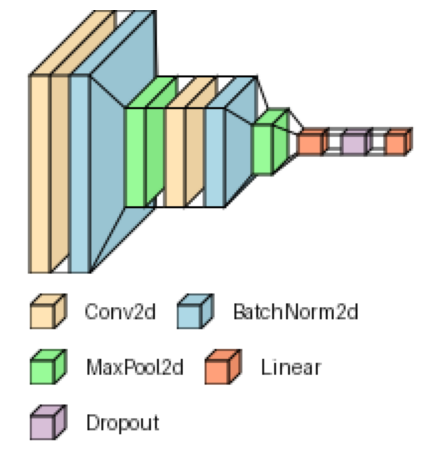

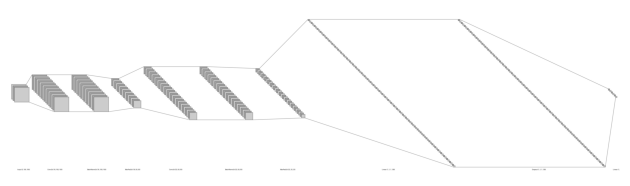

In [11]:
# Define input shape and number of classes for the CNN
input_shape = (3, X.shape[2], X.shape[3])  # (C, H, W)
num_classes = len(np.unique(y))
model = CNN(input_shape, num_classes)

# Visualize the model architecture
summary(model, input_size=input_shape)

img = visualtorch.layered_view(model, input_shape=(1, *input_shape), legend=True, to_file="cnn_layered_view.png")
plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

img = visualtorch.lenet_view(model, input_shape=(1, *input_shape), to_file="cnn_lenet_view.png")

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()


Epoch 1/15 - Train Loss: 2.4362, Train Acc: 0.3570, Test Acc: 0.4842


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2/15 - Train Loss: 1.3740, Train Acc: 0.4535, Test Acc: 0.5333


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 3/15 - Train Loss: 1.3242, Train Acc: 0.4719, Test Acc: 0.5193


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 4/15 - Train Loss: 1.3343, Train Acc: 0.4868, Test Acc: 0.5509


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 5/15 - Train Loss: 1.3572, Train Acc: 0.4395, Test Acc: 0.5333


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 6/15 - Train Loss: 1.2551, Train Acc: 0.4921, Test Acc: 0.5439


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 7/15 - Train Loss: 1.2051, Train Acc: 0.5132, Test Acc: 0.5439


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 8/15 - Train Loss: 1.1982, Train Acc: 0.5096, Test Acc: 0.4877


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 9/15 - Train Loss: 1.1905, Train Acc: 0.5167, Test Acc: 0.5789


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 10/15 - Train Loss: 1.1687, Train Acc: 0.5237, Test Acc: 0.5614


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 11/15 - Train Loss: 1.1504, Train Acc: 0.5465, Test Acc: 0.6035


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 12/15 - Train Loss: 1.1356, Train Acc: 0.5351, Test Acc: 0.5088


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 13/15 - Train Loss: 1.1625, Train Acc: 0.5325, Test Acc: 0.5719


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 14/15 - Train Loss: 1.0988, Train Acc: 0.5553, Test Acc: 0.5719


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 15/15 - Train Loss: 1.1123, Train Acc: 0.5465, Test Acc: 0.5614
Training complete.


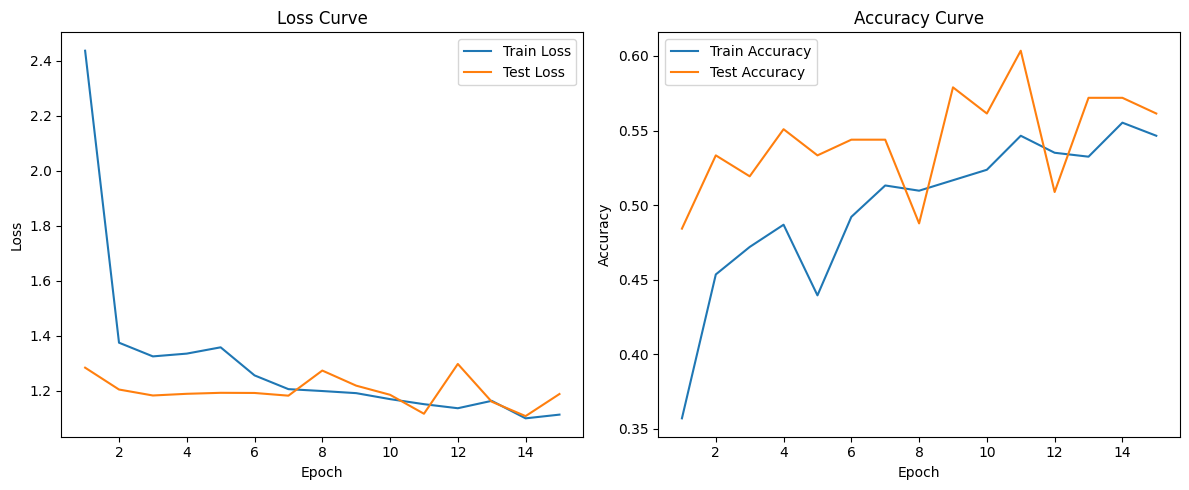

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



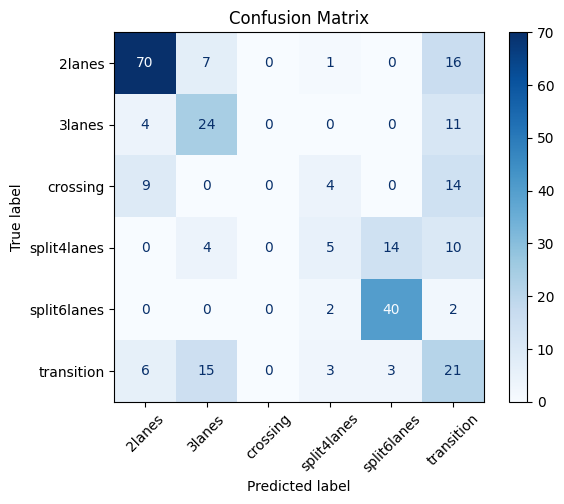

Test Accuracy: 0.5614, Precision: 0.5198, Recall: 0.5614, IoU: 0.4046


In [88]:
# Train the model
train_model(model, train_loader, test_loader, num_epochs=15, learning_rate=0.001)
eval_metrics = evaluate_model(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"), class_names=labels)
accuracy = eval_metrics['accuracy']
precision = eval_metrics['precision']
recall = eval_metrics['recall']
iou = eval_metrics['IoU']
# Print evaluation metrics
print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

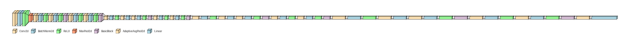

In [12]:
# use a pre-trained model from torchvision
from torchvision import models
# Load a pre-trained ResNet model
resnet = models.resnet18(pretrained=True)
input_shape = (3, X.shape[2], X.shape[3])  # (C, H, W)
num_classes = len(np.unique(y))

# Visualize the model architecture
summary(resnet, input_size=input_shape)

img = visualtorch.layered_view(resnet, input_shape=(1, *input_shape), legend=True, to_file="resnet18_architecture.png")
plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

img = visualtorch.lenet_view(resnet, input_shape=(1, *input_shape), to_file="resnet18_lenet_view.png")

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

In [ ]:
# Modify the last layer to match the number of classes in our dataset
num_ftrs = resnet.fc.in_features
num_classes = len(np.unique(y))  # Number of classes in the dataset
resnet.fc = nn.Linear(num_ftrs, num_classes)  # Replace the last layer with a new one
# Define the model
model = resnet
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Train the model using the same training function
train_model(model, train_loader, test_loader, num_epochs=15, learning_rate=0.001)
# Evaluate the model
eval_metrics = evaluate_model(model, test_loader, device, class_names=labels)
accuracy = eval_metrics['accuracy']
precision = eval_metrics['precision']
recall = eval_metrics['recall']
iou = eval_metrics['IoU']
# Print evaluation metrics
print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")

In [14]:
# use resnet18 with transfer learning
from torchvision import models
# Load a pre-trained ResNet model
resnet = models.resnet18(pretrained=True)
# Modify the last layer to match the number of classes in our dataset
num_ftrs = resnet.fc.in_features
num_classes = len(np.unique(y))  # Number of classes in the dataset
resnet.fc = nn.Linear(num_ftrs, num_classes)  # Replace the last layer with a new one
# Define the model
model = resnet
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Freeze the layers except the last layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers
model.fc.requires_grad = True  # Unfreeze the last layer
# Train all weights of the last layer
train_model(model, train_loader, test_loader, num_epochs=15, learning_rate=0.001)

# Evaluate the model
eval_metrics = evaluate_model(model, test_loader, device, class_names=labels)
accuracy = eval_metrics['accuracy']
precision = eval_metrics['precision']
recall = eval_metrics['recall']
iou = eval_metrics['IoU']
# Print evaluation metrics
print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

We have analyzed different settings for the input shape of the images generated from the point clouds. The following charts represent the results of using an image shape of 200x200 pixels:

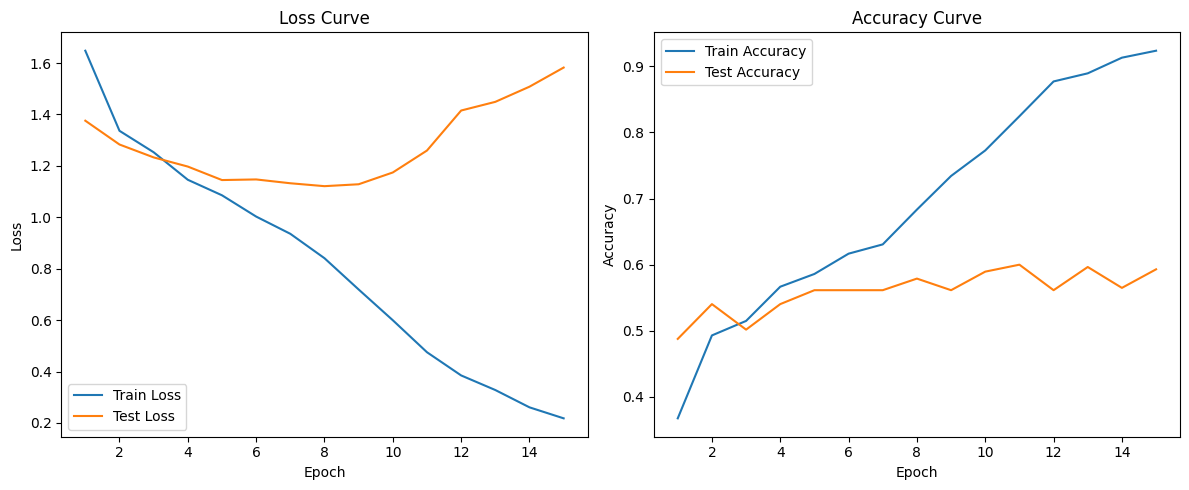
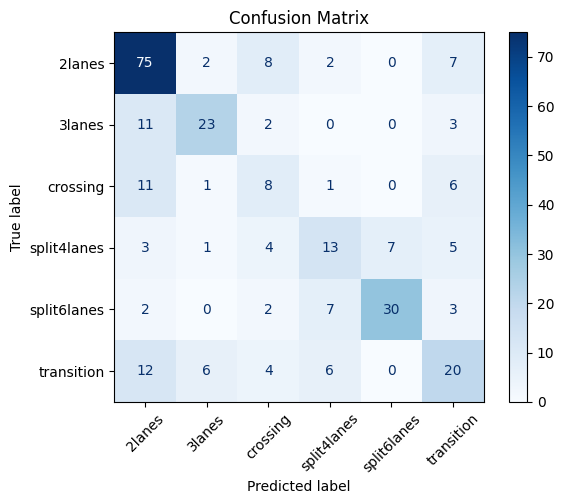

The following charts represent the results of using an image shape of 100x100 pixels:
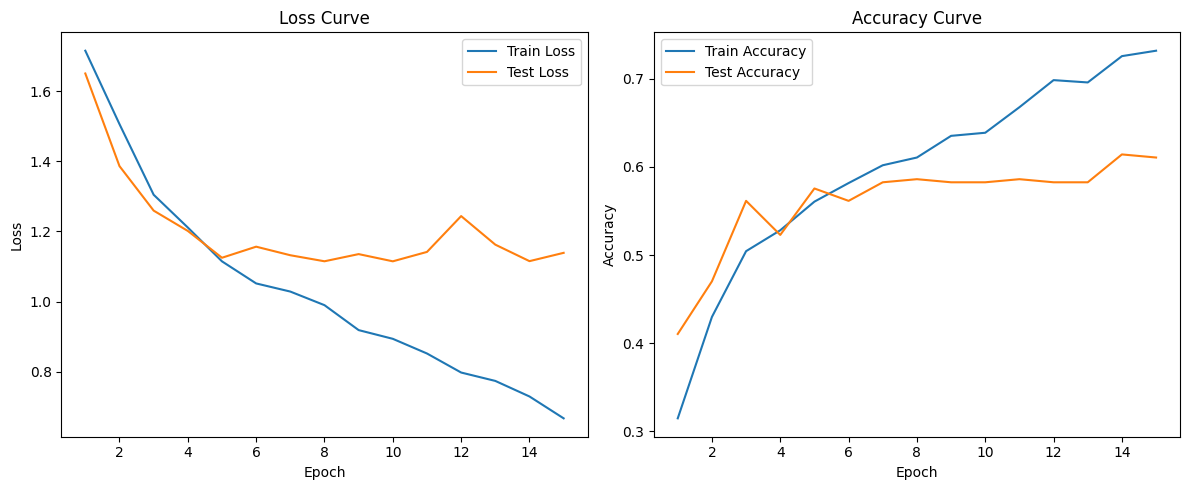
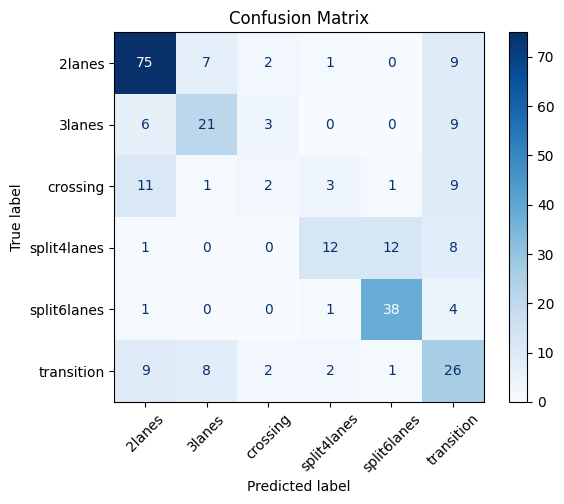

# PointNet
Finally, after some literature research, we came up with the idea to classify our dataset by using an adapted version of the classification model for point clouds PointNet.

In [13]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F


class STN3d(nn.Module):
    def __init__(self, input_shape):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False, input_shape=(3, 2500)):
        super(PointNetfeat, self).__init__()
        self.stn = STNkd(k=input_shape[0])  # Spatial Transformer Network for input shape
        self.conv1 = torch.nn.Conv1d(input_shape[0], 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=input_shape[0])  # Feature Transformer Network for input shape

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x#, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetCls(nn.Module):
    def __init__(self, num_classes=2, feature_transform=False, input_shape=(3, 2500)):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform, input_shape=input_shape)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)#, trans, trans_feat


class PointNetDenseCls(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseCls, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

# if __name__ == '__main__':
#     sim_data = Variable(torch.rand(32,3,2500))
#     trans = STN3d()
#     out = trans(sim_data)
#     print('stn', out.size())
#     print('loss', feature_transform_regularizer(out))

#     sim_data_64d = Variable(torch.rand(32, 64, 2500))
#     trans = STNkd(k=64)
#     out = trans(sim_data_64d)
#     print('stn64d', out.size())
#     print('loss', feature_transform_regularizer(out))

#     pointfeat = PointNetfeat(global_feat=True)
#     out, _, _ = pointfeat(sim_data)
#     print('global feat', out.size())

#     pointfeat = PointNetfeat(global_feat=False)
#     out, _, _ = pointfeat(sim_data)
#     print('point feat', out.size())

#     cls = PointNetCls(k = 5)
#     out, _, _ = cls(sim_data)
#     print('class', out.size())

#     seg = PointNetDenseCls(k = 3)
#     out, _, _ = seg(sim_data)
#     print('seg', out.size())

In [14]:
# load dataset for PointNet model as torch tensors
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import os
def convert_pc_to_tensor(dataset):
    """
    Loads point clouds from the specified folder and labels.

    Args:
        labels (list): List of category labels to load.
        folder_path (str): Path to the folder containing point cloud files.

    Returns:
        tensor: List of point clouds loaded from the specified files.
    """
    X_tensors = []
    y_tensor = torch.tensor([], dtype=torch.long)
    for pc in dataset:
        X_tensors.append(torch.tensor(pc[:, :-1]))
        label_value = pc[0, -1]
        # Map numeric label to string label for index lookup
        # Convert label_value (float) to int, then to string label
        label_idx = int(label_value)
        if y_tensor.dim() == 0 or y_tensor.numel() == 0:
            y_tensor = torch.tensor([label_idx], dtype=torch.long)
        else:
            y_tensor = torch.cat((y_tensor, torch.tensor([label_idx], dtype=torch.long)))
    X_tensor = torch.stack(X_tensors) if X_tensors else torch.empty(0, 0)
    if X_tensor.dim() == 2:
        X_tensor = X_tensor.unsqueeze(0)
    if y_tensor.dim() == 1:
        y_tensor = y_tensor.unsqueeze(0)
    return X_tensor, y_tensor.transpose(0, 1)  # Transpose to match (N, C) format


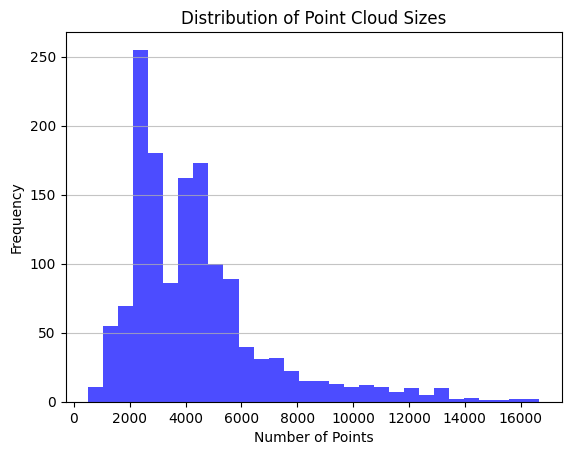

Shape of smallest point cloud: (510, 23)
Shape of largest point cloud: (16661, 23)
Downsampled dataset size: 1308 point clouds
Loaded point clouds shape: torch.Size([1308, 2000, 22]), Labels shape: torch.Size([1308, 1])


In [17]:
labels = ["2lanes", "3lanes", "crossing", "split4lanes", "split6lanes", "transition"]
# Load point clouds
dataset = load_point_clouds(labels, folder_path="dataset/")  # Load point clouds from the specified folder
# Create distribution plot of point cloud sizes
point_cloud_sizes = [pc.shape[0] for pc in dataset]
plt.hist(point_cloud_sizes, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Point Cloud Sizes')
plt.xlabel('Number of Points')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Downsample point clouds
dataset_downsampled = downsample_point_clouds(dataset, min_points=2000)  # Downsample dataset to a minimum of 2000 points
print(f"Downsampled dataset size: {len(dataset_downsampled)} point clouds")

X, y = convert_pc_to_tensor(dataset_downsampled)
# Print the shape of the loaded tensors
print(f"Loaded point clouds shape: {X.shape}, Labels shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Wrap in DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2000]           1,472
       BatchNorm1d-2             [-1, 64, 2000]             128
            Conv1d-3            [-1, 128, 2000]           8,320
       BatchNorm1d-4            [-1, 128, 2000]             256
            Conv1d-5           [-1, 1024, 2000]         132,096
       BatchNorm1d-6           [-1, 1024, 2000]           2,048
            Linear-7                  [-1, 512]         524,800
       BatchNorm1d-8                  [-1, 512]           1,024
            Linear-9                  [-1, 256]         131,328
      BatchNorm1d-10                  [-1, 256]             512
           Linear-11                  [-1, 484]         124,388
            STNkd-12               [-1, 22, 22]               0
           Conv1d-13             [-1, 64, 2000]           1,472
      BatchNorm1d-14             [-1, 6

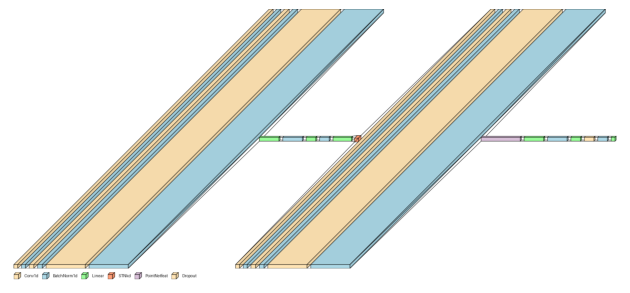

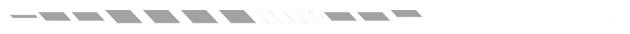

In [18]:
# Define input shape and number of classes for the PointNet
# PointNet expects input shape: (batch_size, num_features, num_points)
batch_size = 16  # PointNet processes specified number of point clouds at a time

num_samples = X.shape[0]  # Number of point clouds
num_features = X.shape[2]    # 22 (number of features per point)
num_points = X.shape[1]      # 510 (number of points per cloud)
input_shape = (num_features, num_points)  # (22, 510)
num_classes = len(np.unique(y))
model = PointNetCls(num_classes, feature_transform=False, input_shape=input_shape)  # Pass input_shape

summary(model, input_size=input_shape)

img = visualtorch.layered_view(model, input_shape=(batch_size, *input_shape), legend=True, to_file="pointnet_architecture.png")
plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

img = visualtorch.lenet_view(model, input_shape=(batch_size, *input_shape), to_file="pointnet_lenet_view.png")

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

In [19]:
# --- Training and Evaluation of the PointNet model --- (Jonas)

def train_point_net(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()            # Clear previous gradients
            outputs = model(inputs)          # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()                  # Backpropagation
            optimizer.step()                 # Update weights

            running_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        eval_metrics = evaluate_model(model, test_loader, device, silent=True)
        test_loss = eval_metrics['loss']
        test_acc = eval_metrics['accuracy']

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    print("Training complete.")
    plot_learning_curves(train_losses, test_losses, train_accuracies, test_accuracies)

# Evaluation with confusion matrix
def evaluate_point_net(model, test_loader, device, class_names=None, silent=False):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total 

    # calculate accuracy, precision, recall, and IoU
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    iou = jaccard_score(all_labels, all_preds, average='weighted')
    eval_metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'IoU': iou
    }

    if not silent and class_names:
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title("Confusion Matrix")
        plt.show()

    return eval_metrics

d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1/15 - Train Loss: 1.4935, Train Acc: 0.4398, Test Acc: 0.3359


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 2/15 - Train Loss: 1.3844, Train Acc: 0.5086, Test Acc: 0.3092
Epoch 3/15 - Train Loss: 1.2093, Train Acc: 0.5535, Test Acc: 0.3092


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 4/15 - Train Loss: 1.2370, Train Acc: 0.5564, Test Acc: 0.4466
Epoch 5/15 - Train Loss: 1.1995, Train Acc: 0.5583, Test Acc: 0.4160


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 6/15 - Train Loss: 1.1672, Train Acc: 0.5660, Test Acc: 0.4809
Epoch 7/15 - Train Loss: 1.1367, Train Acc: 0.5985, Test Acc: 0.4542
Epoch 8/15 - Train Loss: 1.0949, Train Acc: 0.5908, Test Acc: 0.3130


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 9/15 - Train Loss: 1.0938, Train Acc: 0.5927, Test Acc: 0.3282


d:\repos\Road_Point_Cloud_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 10/15 - Train Loss: 1.0392, Train Acc: 0.6042, Test Acc: 0.3053
Epoch 11/15 - Train Loss: 1.0496, Train Acc: 0.6157, Test Acc: 0.5687
Epoch 12/15 - Train Loss: 0.9817, Train Acc: 0.6338, Test Acc: 0.4237
Epoch 13/15 - Train Loss: 1.0237, Train Acc: 0.6243, Test Acc: 0.3550
Epoch 14/15 - Train Loss: 1.0171, Train Acc: 0.6243, Test Acc: 0.4771
Epoch 15/15 - Train Loss: 0.9877, Train Acc: 0.6291, Test Acc: 0.5153
Training complete.


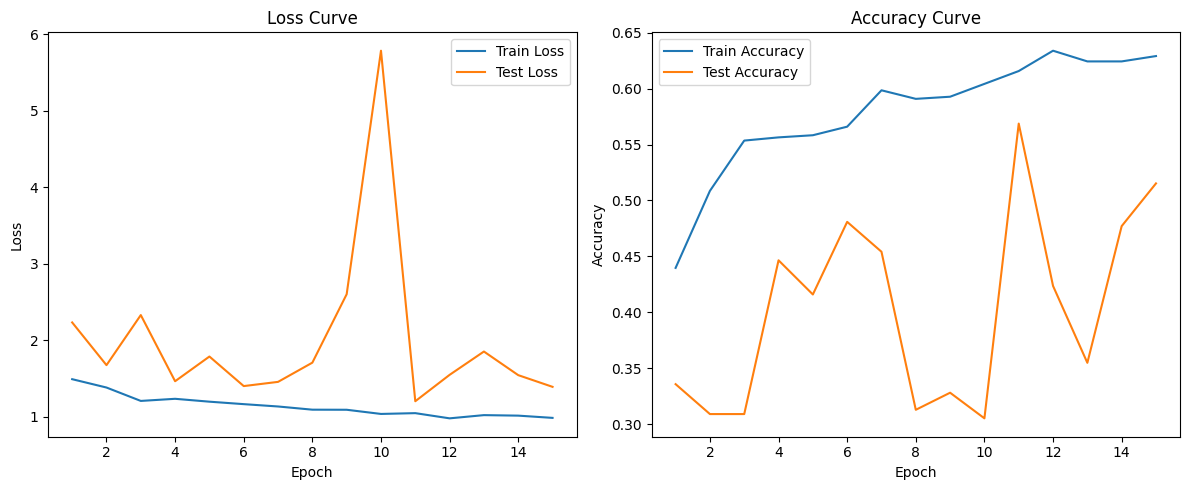

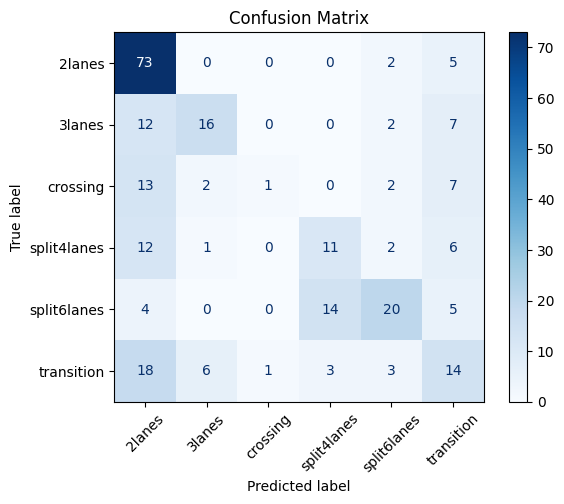

Test Accuracy: 0.5153, Precision: 0.5155, Recall: 0.5153, IoU: 0.3334


In [20]:
# Ensure input tensors are float32 for model compatibility
X_train = X_train.float()
X_test = X_test.float()

# Transpose to (batch_size, num_features, num_points) for PointNet
X_train = X_train.transpose(1, 2)
X_test = X_test.transpose(1, 2)

# Re-create DataLoaders with the correct shape and dtype
train_dataset = TensorDataset(X_train, y_train.squeeze())
test_dataset = TensorDataset(X_test, y_test.squeeze())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Train the model
train_point_net(model, train_loader, test_loader, num_epochs=15, learning_rate=0.001)
eval_metrics = evaluate_point_net(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"), class_names=labels)
accuracy = eval_metrics['accuracy']
precision = eval_metrics['precision']
recall = eval_metrics['recall']
iou = eval_metrics['IoU']
# Print evaluation metrics
print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")
